<a href="https://colab.research.google.com/github/MrDeiv/unica-isde/blob/main/NMC_ex1__Industrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt

def load_minst_data(filename):
  data = pn.read_csv(filename)
  data = np.array(data)

  y = data[:,0] #all rows and first column
  x = data[:,1:] / 255 #all rows and remaing columns 

  return x,y

#print(y.shape,x.shape)
#print(y[0:10], x[0:10,:])

filename = 'sample_data/mnist_train_small.csv'
x, y = load_minst_data(filename)


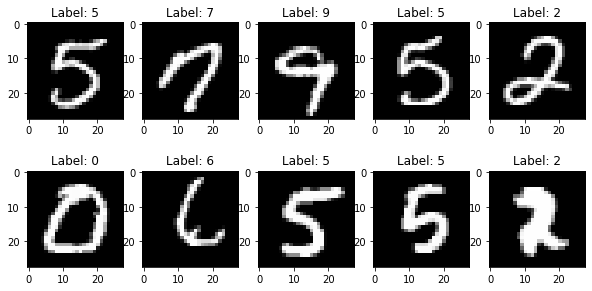

In [3]:
#plottinf utils

image = x[0,:]

def plot_digit(image, shape=(28,28)):
  plt.imshow(np.reshape(image, newshape = (28,28)), 'gray')

def plot_ten_digits(x,y=None):
  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plot_digit(x[i,:])
    if y is not None:
      plt.title('Label: ' + str(y[i]))

plot_ten_digits(x,y)

In [4]:
# count how many images we have for each class

class_labels = np.unique(y)
n_classes = np.size(class_labels) #how many classes we have (class_labels.size or class_labels.shape[0])

count = np.zeros(shape=(10,), dtype=int) #verctor of zeros

''' for label in y:
  count[label] += 1
 '''

for k in range(n_classes):
  count[k] = (y == k).sum()

print(count)

[1962 2243 1989 2021 1924 1761 2038 2126 1912 2023]


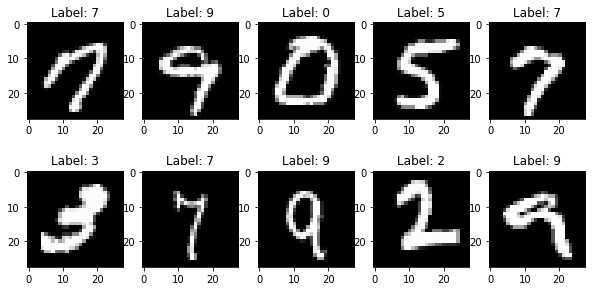

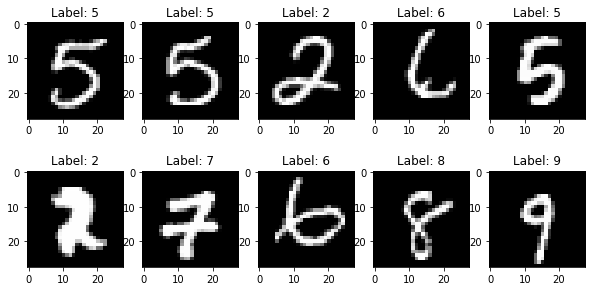

In [5]:
#split data

tr_fraction = 0.8

# xtr, ytr, xts, yts = split_data(x, y, tr_fraction)

#Bernulli distribution for repeated trials

def split_data(x, y, tr_fraction=.5):

  n_samples = y.size
  n_tr = int(tr_fraction * n_samples)
  n_ts = n_samples - n_tr

  tr_idx = np.zeros(shape=(n_samples,))
  tr_idx[0:n_tr] = 1 # 1 = training, 0 = test

  np.random.shuffle(tr_idx) #in place operation - it modifies the object inside

  ytr = y[tr_idx == 1]
  xtr = x[tr_idx == 1, :]

  yts = y[tr_idx == 0]
  xts = x[tr_idx == 0, :]

  return xtr, ytr, xts, yts
  

xtr, ytr, xts, yts = split_data(x, y)

plot_ten_digits(xtr, ytr)
plot_ten_digits(xts, yts)

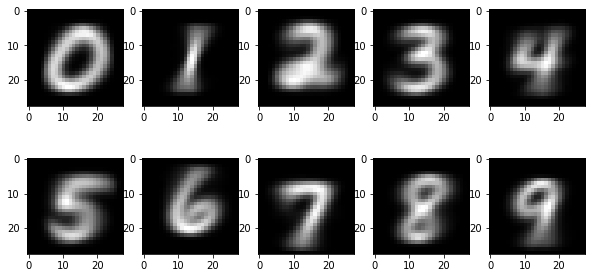

In [6]:
# fit function: centroids = (xtr, ytr)

def fit(xtr, ytr):
  n_classes = np.unique(ytr).size
  n_features = xtr.shape[1]

  centroids = np.zeros(shape=(n_classes, n_features))

  for k in range(n_classes):
    xk = xtr[ytr==k, :]
    centroids[k, :] = np.mean(xk, axis=0)
  
  return centroids


centroids = fit(xtr, ytr)

plot_ten_digits(centroids)

In [40]:
# compute distance matrix between xts and centroids

#from sklearn.matrics import pairwise_distances
from sklearn.metrics import pairwise_distances
import time

n_ts_samples = xts.shape[0]
n_centroids = centroids.shape[0]

dist = np.zeros(shape=(n_ts_samples, n_centroids))
dist1 = np.zeros(shape=(n_ts_samples, n_centroids))

t0 = time.time()

for i in range(n_ts_samples):
  for j in range(n_centroids):
    dist[i,j] = np.linalg.norm(xts[i, :] - centroids[j, :], ord=2) #euclidian norm

t1 = time.time()
print("1) Elapsed time in msec: ", t1-t0)

t0 = time.time()

for j in range(n_centroids):
    dist1[:, j] = np.linalg.norm(xts - centroids[j,:], ord=2, axis=1)

t1 = time.time()
print("2) Elapsed time in msec: ", t1-t0)

print((dist-dist1 > 1e-12).sum())

t0 = time.time()
dist2 = pairwise_distances(xts, centroids)
t1 = time.time()
print("3) Elapsed time in msec: ", t1-t0)

y_pred = np.argmin(dist, axis=1)

def predict(xts, centroids):
  dist2 = pairwise_distances(xts, centroids)

  y_pred = np.argmin(dist, axis=1)
  return y_pred

y_pred = predict(xts, centroids)

#test error
def test_error(y_pred, yts):
  return (y_pred != yts).mean()

print(test_error(y_pred, yts))


1) Elapsed time in msec:  0.9007129669189453
2) Elapsed time in msec:  0.30800700187683105
0
3) Elapsed time in msec:  0.06732058525085449
0.8628


In [42]:
#implement the full pipeline. Input: X, y --> Output: mean_test_error, std_dev

x, y = load_minst_data(filename)

n_reps = 100
ts_errs = np.zeros(shape=(n_reps,))

for rep in range(n_reps):
  xtr, yts, xts, yts = split_data(x, y)
  centroids = fit(xtr, ytr)
  y_pred = predict(xts, centroids)
  ts_errs[rep] = test_error(y_pred, yts)

print(ts_errs.mean(), 2*ts_errs.std())

0.8991250000000001 0.006283717052827877
